# Visualize gene expression

This notebook visualizes the gene expression data for the template and simulated experiments in order to:
1. Validate that the structure of the gene expression data and simulated data are consistent
2. To visualize the signal that is in the experiments

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import umap
import pickle
import glob
import seaborn as sns
from sklearn.decomposition import PCA
from keras.models import load_model
import plotnine as pn

from ponyo import utils
from generic_expression_patterns_modules import plot

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


## Load config parameters

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params

local_dir = params['local_dir']
project_id = params['project_id']
num_simulated = params['num_simulated']

pval_name = "adj.P.Val"
logFC_name = "logFC"
run=0

# Settings for running visualization using pseudomonas config file
vae_model_dir = os.path.join(base_dir,"pseudomonas_analysis", "models", "NN_2500_30")
template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']

## Volcano plots

In [5]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats[pval_name]<0.01) & (abs(template_DE_stats[logFC_name])>1)]
print(selected.shape)

(109, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


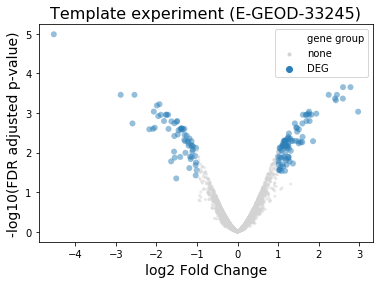

In [6]:
plot.make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
    pval_name,
    logFC_name
)

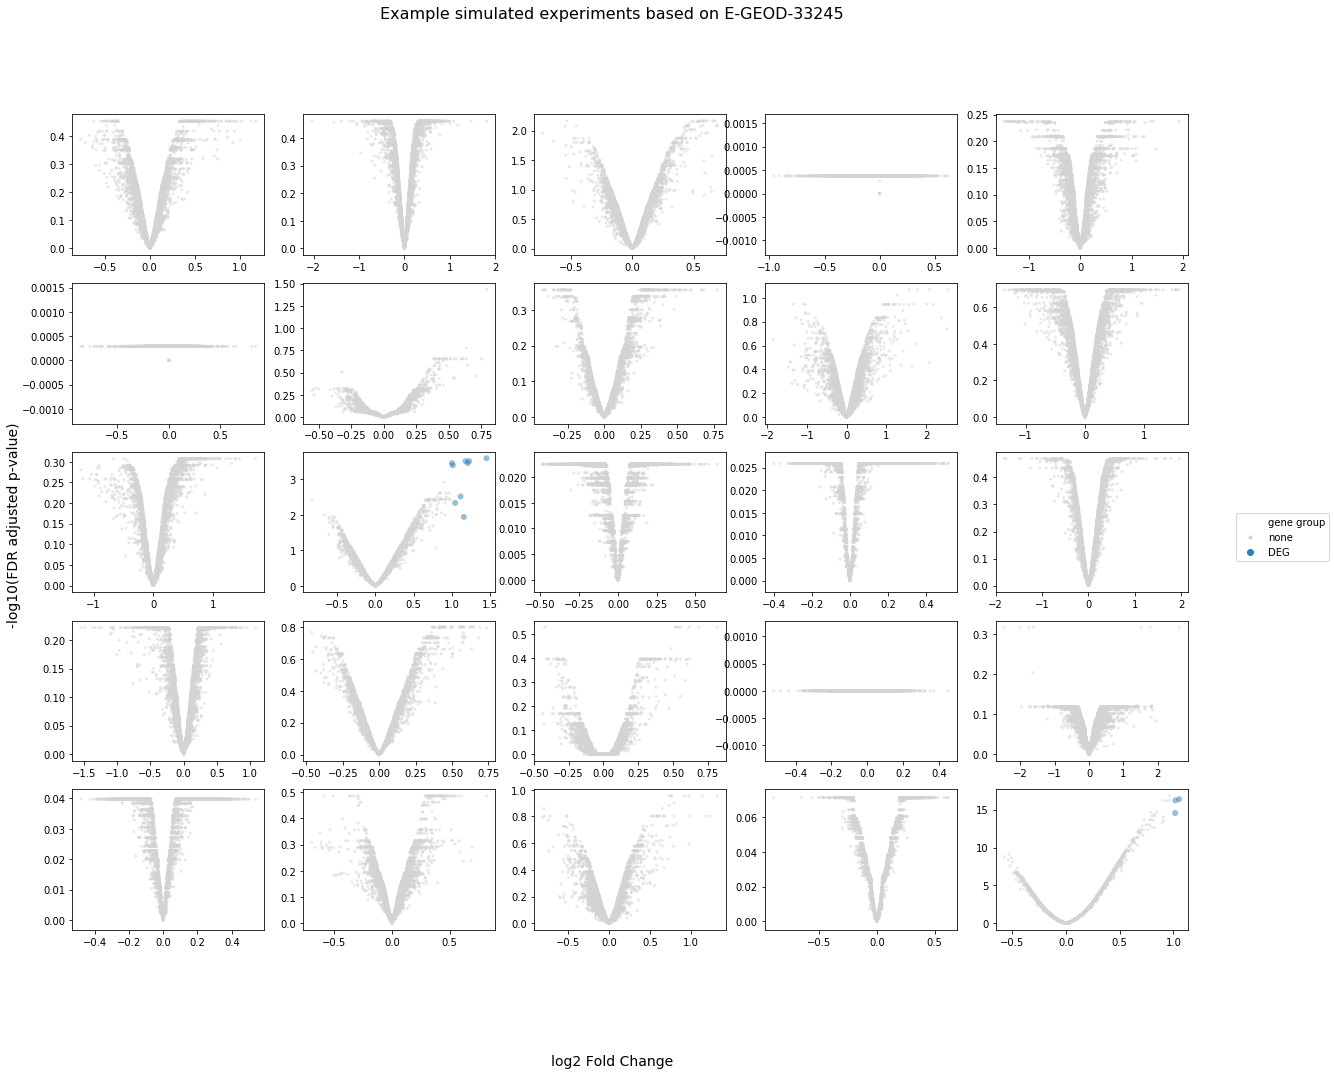

In [7]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")

plot.make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    5,
    5,
    20,
    15
)

## Explore flat volcano plots

Why are some volcano plots flat?

In [8]:
# Lets look at the expression data for the volcano plot with DEGs
simulated_expression_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_11.txt"
)

simulated_expression = pd.read_csv(
    simulated_expression_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

simulated_expression

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM822708_wtLB_A.CEL,8.054,9.578,8.094,8.513,6.998,7.385,8.158,8.205,7.571,5.719,...,7.176,8.753,8.894,8.737,8.631,7.019,7.689,9.781,10.511,9.136
GSM822709_wtLB_B.CEL,8.204,9.717,8.216,8.870,7.230,7.657,8.160,8.136,7.648,5.709,...,7.511,8.713,8.850,8.756,8.575,6.729,7.498,9.575,10.656,9.207
GSM822712_delta_cbrBLB_A.CEL,8.418,9.866,8.263,8.713,7.165,7.476,8.312,8.258,7.730,5.680,...,7.263,8.822,9.182,8.878,8.827,6.215,7.488,9.528,10.651,9.604
GSM822713_delta_cbrBLB_B.CEL,8.102,9.599,8.048,8.464,6.971,7.375,8.298,8.139,7.470,5.681,...,7.170,8.735,9.006,8.755,8.771,6.603,7.610,9.559,10.543,9.328


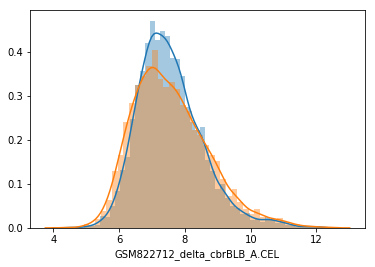

In [9]:
sns.distplot(simulated_expression.loc["GSM822708_wtLB_A.CEL"])
sns.distplot(simulated_expression.loc["GSM822712_delta_cbrBLB_A.CEL"])

In [10]:
# Lets look at the expression data for the flat volcano plot
simulated_expression_filename = os.path.join(
    local_dir,
    "pseudo_experiment",
    f"selected_simulated_data_{project_id}_5.txt"
)

flat_simulated_expression = pd.read_csv(
    simulated_expression_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

flat_simulated_expression

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM822708_wtLB_A.CEL,9.263,10.416,9.071,9.431,7.674,7.619,7.221,9.237,8.961,5.619,...,7.495,9.388,10.088,9.884,9.512,6.094,8.034,10.867,11.852,10.868
GSM822709_wtLB_B.CEL,9.323,10.660,9.040,9.714,7.556,7.607,7.164,9.164,9.033,5.624,...,6.911,9.329,9.725,9.933,9.547,5.735,7.982,10.829,11.803,10.929
GSM822712_delta_cbrBLB_A.CEL,9.380,10.605,9.199,9.528,7.903,7.687,7.087,9.263,9.084,5.578,...,7.588,9.500,10.181,10.033,9.678,5.835,7.974,10.879,12.009,11.168
GSM822713_delta_cbrBLB_B.CEL,9.197,10.366,9.009,9.338,7.692,7.631,7.257,9.140,8.831,5.604,...,7.649,9.364,10.044,9.819,9.481,6.081,7.921,10.725,11.797,10.908


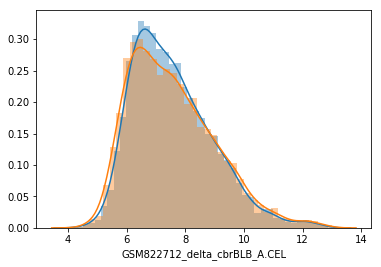

In [11]:
sns.distplot(flat_simulated_expression.loc["GSM822708_wtLB_A.CEL"])
sns.distplot(flat_simulated_expression.loc["GSM822712_delta_cbrBLB_A.CEL"])

In [12]:
# Lets look at the DE stats associated with this flat volcano plot
simulated_DE_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_simulated_data_{project_id}_5.txt"
)

flat_simulated_DE = pd.read_csv(
    simulated_DE_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

flat_simulated_DE

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA3049,4.765000e-01,8.39725,3.201384e+00,0.010261,0.999338,-3.727213
PA3531,3.835000e-01,9.45975,2.942530e+00,0.015730,0.999338,-3.824578
PA4563,6.495000e-01,11.20125,2.898297e+00,0.016928,0.999338,-3.841847
PA3472,4.660000e-01,8.68750,2.857761e+00,0.018108,0.999338,-3.857830
PA3621,5.150000e-01,9.36350,2.852101e+00,0.018279,0.999338,-3.860074
PA3496,4.100000e-01,8.71350,2.802707e+00,0.019846,0.999338,-3.879772
PA5315,6.260000e-01,9.31700,2.761291e+00,0.021264,0.999338,-3.896452
PA3245,4.670000e-01,9.42450,2.730567e+00,0.022381,0.999338,-3.908920
PA2204,-3.900000e-01,8.05300,-2.674675e+00,0.024569,0.999338,-3.931801
PA2747,5.745000e-01,7.34725,2.668687e+00,0.024815,0.999338,-3.934268


In [13]:
# Lets look at the DE stats associated with DEGs volcano plot
simulated_DE_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_simulated_data_{project_id}_11.txt"
)

simulated_DE = pd.read_csv(
    simulated_DE_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

simulated_DE

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PA2746,1.452000e+00,7.71950,1.045692e+01,4.611411e-08,0.000256,8.627466
PA1177,1.225500e+00,7.51125,9.568993e+00,1.405486e-07,0.000308,7.658762
PA4306,1.178000e+00,8.91300,9.439745e+00,1.663766e-07,0.000308,7.509935
PA1728,1.001000e+00,8.99200,9.073154e+00,2.710305e-07,0.000351,7.076420
PA1190,1.206000e+00,9.29950,8.959906e+00,3.160449e-07,0.000351,6.939015
PA2486,1.012000e+00,8.16550,8.725558e+00,4.362973e-07,0.000404,6.649324
PA3451,9.035000e-01,7.30575,7.856716e+00,1.523921e-06,0.001208,5.509609
PA1930,8.530000e-01,8.09500,7.263642e+00,3.774184e-06,0.002425,4.669041
PA3986,8.335000e-01,8.13225,7.135462e+00,4.618900e-06,0.002425,4.480414
PA1465,9.195000e-01,7.51775,7.126021e+00,4.688531e-06,0.002425,4.466421


Flat volcano plots are due to samples between the two groups are very similar, so the log2 fold change is very small 10^-1 for each gene and so the adjusted p-values are nearly the same for each gene. Another artifact of the VAE variance shrinkage.

## Explore leveling out of volcano plots

Why do volcano plots level out at at then extend outward? Is this an issue with the plotting?

In [14]:
import matplotlib.pyplot as plt    
def make_volcano_plot_simulated_notransform(
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    ncols,
    nrows,
    fig_width,
    fig_height,
):
    """
	This function makes multiple volcano plots of example simulated experiments

    Arguments
    ----------
    template_DE_stats_filename: str
        File containing DE statistics for template experiment
    project_id: str
        Experiment identifier
    pval_name: "padj" or "adj.P.Val"
    logFC_name: "logFC" or "log2FoldChange"
    num_simulated: int
        Number of simulated experiments
    ncols: int
        Number of columns in facet plot
    nrows: int
        Number of rows in facet plot
    fig_width: int
        Width of figure
    fig_height: ing
        Height of figure

	"""
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, fig_height))

    axes = axes.ravel()

    for i in range(num_simulated):

        # Get filename
        simulated_DE_stats_filename = os.path.join(
            simulated_DE_stats_dir, f"DE_stats_simulated_data_{project_id}_{i}.txt",
        )

        # Read simulated DE stats
        simulated_DE_stats_df = pd.read_csv(
            simulated_DE_stats_filename, sep="\t", index_col=0, header=0
        )

        # Take -log10 of adjusted p-value
        simulated_DE_stats_df["padj_log10"] = -(simulated_DE_stats_df[pval_name])

        # Label DEGs by traditional criteria
        # log2FC > 1
        # padj < 0.05
        simulated_DE_stats_df["gene group"] = "none"
        simulated_DE_stats_df.loc[
            (abs(simulated_DE_stats_df[logFC_name]) > 1)
            & (simulated_DE_stats_df[pval_name] < 0.05),
            "gene group",
        ] = "DEG"

        # Plot
        colors = ["lightgrey", "#2c7fb8"]

        if i == 0:
            f = sns.scatterplot(
                data=simulated_DE_stats_df,
                x=logFC_name,
                y="padj_log10",
                hue="gene group",
                hue_order=["none", "DEG"],
                style="gene group",
                markers={"none": ".", "DEG": "o",},
                palette=colors,
                linewidth=0,
                alpha=0.5,
                legend="full",
                ax=axes[i],
            )

            axes[i].set_ylabel("")
            axes[i].set_xlabel("")
            handles, labels = f.get_legend_handles_labels()
            fig.legend(handles, labels, loc="center right")
            f.legend_.remove()

        else:
            f = sns.scatterplot(
                data=simulated_DE_stats_df,
                x=logFC_name,
                y="padj_log10",
                hue="gene group",
                hue_order=["none", "DEG"],
                style="gene group",
                markers={"none": ".", "DEG": "o",},
                palette=colors,
                linewidth=0,
                alpha=0.5,
                legend=False,
                ax=axes[i],
            )

            axes[i].set_ylabel("")
            axes[i].set_xlabel("")

    fig.text(0.5, 0.0, "log2 Fold Change", ha="center", fontsize=14, fontname="Verdana")
    fig.text(
        0.08,
        0.5,
        "-(FDR adjusted p-value)",
        va="center",
        rotation="vertical",
        fontsize=14,
        fontname="Verdana",
    )
    fig.suptitle(
        f"Example simulated experiments based on {project_id}",
        fontsize=16,
        fontname="Verdana",
    )

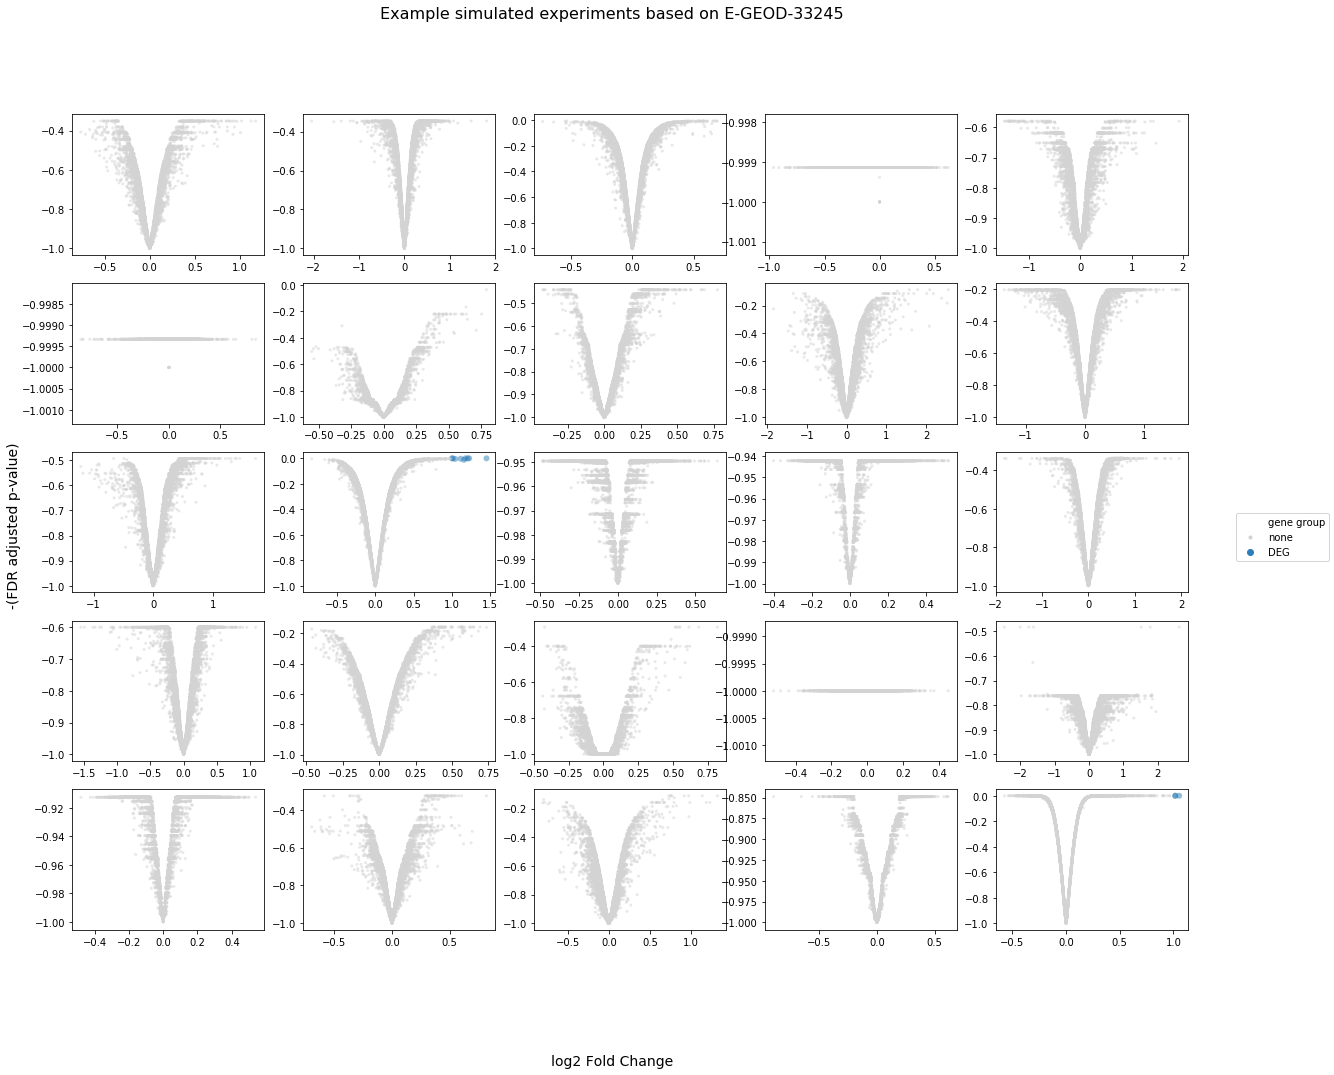

In [15]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")

make_volcano_plot_simulated_notransform(
    simulated_DE_stats_dir,
    project_id,
    pval_name,
    logFC_name,
    num_simulated,
    5,
    5,
    20,
    15
)

There is still a leveling off but it doesn't look as dramatic if we don't take the log10 but just negate the adjusted p-values.

In [25]:
# Let's look at the distribution of adjusted p-value scores for those volcano
# plots that level off as increase logFC
simulated_DE_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_simulated_data_{project_id}_1.txt"
)

leveloff_simulated_DE = pd.read_csv(
    simulated_DE_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

In [26]:
# Compare the distribution of adjusted p-value scores
# for the volcano plot that doesn't level off as much
# as we increase logFC
simulated_DE_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_simulated_data_{project_id}_2.txt"
)

simulated_DE = pd.read_csv(
    simulated_DE_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

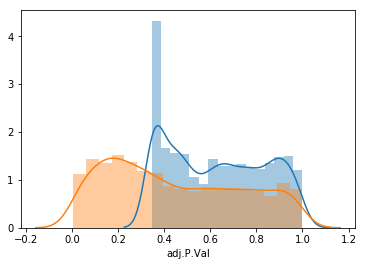

In [27]:
sns.distplot(leveloff_simulated_DE[pval_name])
sns.distplot(simulated_DE[pval_name])

Looks like there is a peak of adjusted p-values at the minimum range of the distribution which is causing the leveling out (i.e. there are many genes with a similar low adjusted p-value). I am guessing this is also a result of the VAE shrinkage, where instead of genes having varying logFC, genes are compressed such that there are groups of genes with similar logFC and therefore similar adjusted p-values.